In [1]:
#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense

<ipython-input-1-b74afd5c5bb8>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## Data Cleaning


In [3]:
#storing a original df for refrence
original_df = df.copy()

In [4]:
#information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [5]:
# from the above information we can see that column "car" has only 108 not null value
# hence, we are removing it from the dataframe
# Moreover, the column "toCoupon_GE5min" doesnt correspont to any Restaurant within 5 minutes hence removing the same
df.drop(columns=["car", "toCoupon_GEQ5min"], inplace = True)

In [6]:
#checking the shape of the dataframe
df.shape

(12684, 24)

In [7]:
#droped the duplicate rows in the dataframe
df = df.drop_duplicates()
df.shape

(12610, 24)

In [8]:
#checking for missing values
df.isnull().sum()
#we can observe that there are some missing values in the data

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               150
RestaurantLessThan20    129
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
direction_opp             0
Y                         0
dtype: int64

In [9]:
# To deal with the missing data we observed the statistics of the columns with missing value
# for determining how to deal with the missing data
print((df[['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']].describe()))
# we made a copy of dataframe and tried two method one by dropping the row of missing value 
# and the other by replacing it with mode value
df_copy1 = df.copy()
df_copy2 = df.copy()

# removed the rows from df_copy1
df_copy1.dropna(inplace = True)
 
# replacing with mode value in df_copy2
df_copy2 = df_copy2.fillna(df_copy2.mode().iloc[0])

          Bar CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50
count   12503       12393     12460                12481            12421
unique      5           5         5                    5                5
top     never       less1       1~3                  1~3            less1
freq     5178        3362      4645                 5356             6041


In [10]:
#copmare both the columns for changes
print((df_copy1[['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']].describe()), end = "\n\n")
print("shape of dataframe after removing missing values = ",df_copy1.shape, sep="", end = "\n\n\n")
print((df_copy2[['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']].describe()))

#For this we choose to remove the missing value
#Later when developing a model we can check the model with replacing the values also
df.dropna(inplace = True)
df.isnull().sum()

          Bar CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50
count   12007       12007     12007                12007            12007
unique      5           5         5                    5                5
top     never       less1       1~3                  1~3            less1
freq     4916        3276      4475                 5143             5825

shape of dataframe after removing missing values = (12007, 24)


          Bar CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50
count   12610       12610     12610                12610            12610
unique      5           5         5                    5                5
top     never       less1       1~3                  1~3            less1
freq     5285        3579      4795                 5485             6230


destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

<AxesSubplot:>

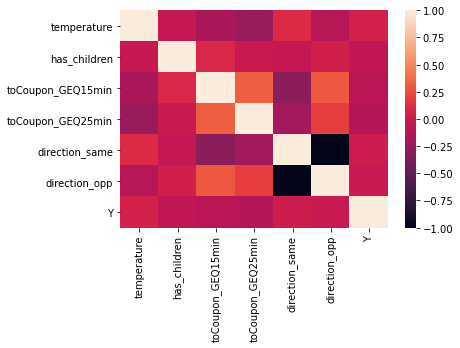

In [11]:
# Correlation of the numerical feature
fig, ax = plt.subplots()
sns.heatmap(df.corr())

In [12]:
# we observe that the columns "direction_same" and "direction_opp" are negetively corelated to each other
# Hence, we are dropping the column "direction_opp"
df.drop(columns=["direction_opp"], inplace = True)

In [13]:
# renaming the output columns "Y" to "coupon_accepted" and correcting the spelling of passenger
df.rename({"Y" : "coupon_accepted", "passanger" : "passenger"}, axis = 1, inplace = True)

In [14]:
#change the expiration time to hr

for i, row in df.iterrows():
    
    if df.at[i, "expiration"].endswith("h"):
        df.at[i, "expiration"] = int(df.at[i, "expiration"][:1])
    else :
        df.at[i, "expiration"] = int(df.at[i, "expiration"][:1]) * 24
df["expiration"] = df["expiration"].astype(int)

## EDA (Exploratory Data Analysis)

Text(0, 0.5, 'number of users')

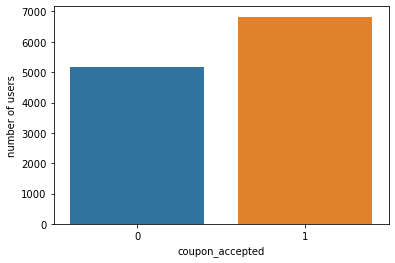

In [15]:
# First we observe the countplot of accepted and rejected coupon
fig, ax = plt.subplots()
sns.countplot(x = df["coupon_accepted"])
ax.set_ylabel("number of users")

#Observation:
# we observe that the acceptance and rejection counts are enough for modelling

Text(0, 0.5, 'Number of users')

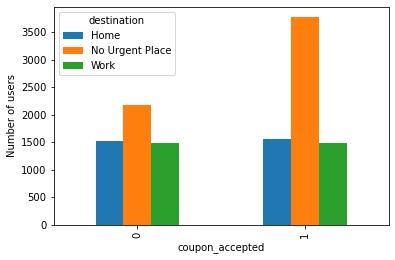

In [16]:
# We are going columns by columns are doing the analysis
# First we oberve the plot between destination and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['destination'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the people who have no urgent place to go are accepting more coupons

Text(0, 0.5, 'Number of users')

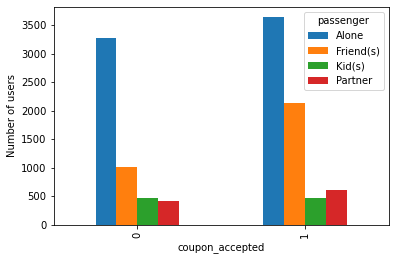

In [17]:
# plot between passenger and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['passenger'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the time users go out alone
# Users going with friends tend to accept more coupons

Text(0, 0.5, 'Number of users')

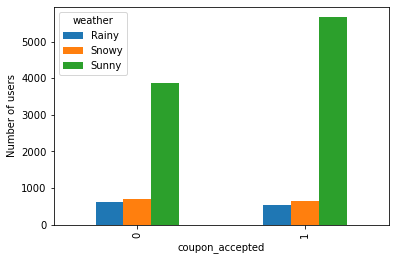

In [18]:
# plot between weather and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['weather'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the time users prefer sunny weather for travelling and accept more in comparision to other weather conditions

Text(0, 0.5, 'Number of users')

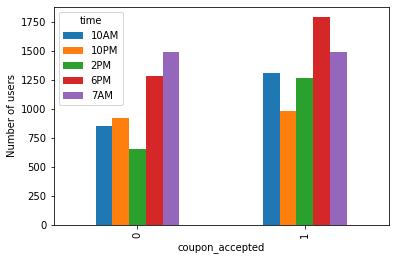

In [19]:
# plot between time and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['time'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the users accepts coupon around the time 10PM and 6PM

Text(0, 0.5, 'Number of users')

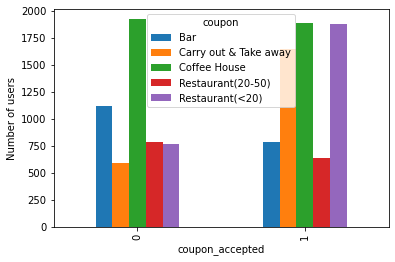

In [20]:
# plot between coupon and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['coupon'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the users accepts coupon of restaurants(<$20) and carry out and take aways

Text(0, 0.5, 'Number of users')

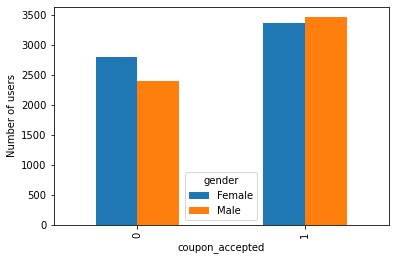

In [21]:
# plot between gender and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['gender'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Rate of acceptance are almost the same

Text(0, 0.5, 'Number of users')

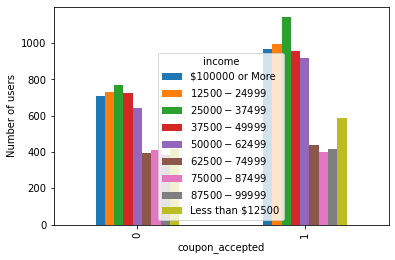

In [22]:
# plot between income and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['income'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the users with less than $12500 and more than $62500 are accepting the coupons

Text(0, 0.5, 'Number of users')

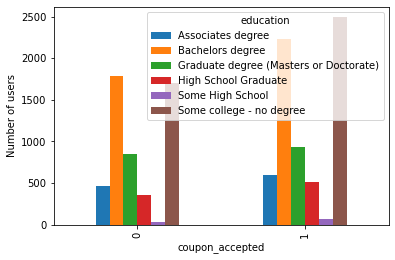

In [23]:
# plot between education and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['education'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the users with no degree or bachelors degree are accepting more coupons

Text(0, 0.5, 'Number of users')

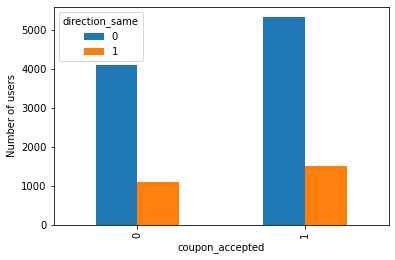

In [24]:
# plot between direction_same and coupon accepted
destination_plot=pd.crosstab(index=df['coupon_accepted'],columns=df['direction_same'])
plot = destination_plot.plot.bar()
plot.set_ylabel("Number of users")

# Observation:
# Most of the users with opposite direction are accepting more coupons

Text(0, 0.5, 'Number of coupons')

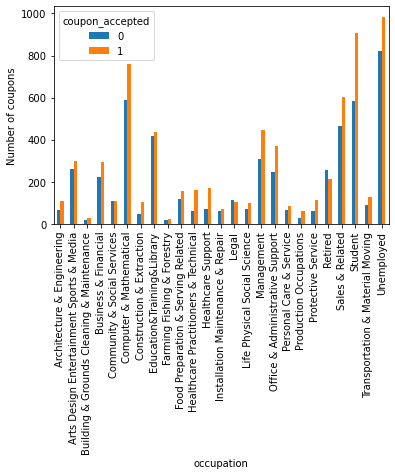

In [25]:
# plot between occupation and coupon accepted
destination_plot=pd.crosstab(index=df['occupation'],columns=df['coupon_accepted'])
plot = destination_plot.plot(kind = "bar")
plot.set_ylabel("Number of coupons")

# Observation:
# users with any occupations are more likely to accept coupons, therefore will remove this attirubutes from the dataset

<AxesSubplot:xlabel='destination', ylabel='count'>

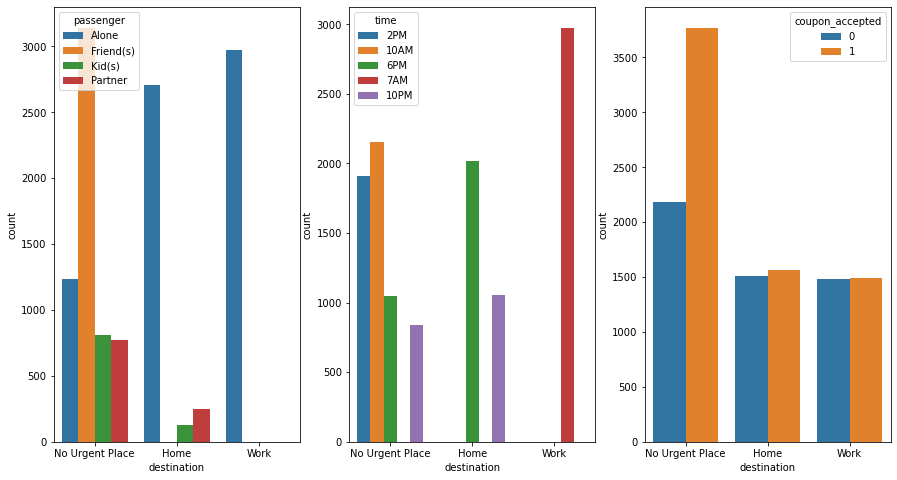

In [26]:
# multivariate graph showing destination vs passanger and destination and time
# to compare at what time the user is travelling and with whome
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
sns.countplot(x = "destination", hue="passenger", data = df ,ax=ax[0])
sns.countplot(x = "destination", hue = "time", data =df, ax = ax[1])
sns.countplot(x = "destination", hue = "coupon_accepted", data = df, ax=ax[2])

# observation
# User going to work has same coupon acceptance rate and doent depend upon either time or passenger and are mostly alone
# User going to/from home also have the same trend 

In [27]:
fig, ax = plt.subplots()
profile = ProfileReport(df, title="EDA Report")
profile

## Data Cleaning after EDA

In [28]:
# drop the columns after EDA
df.drop(columns = ["occupation", "gender","income", "education"], inplace = True)

In [29]:

#standandise the data
df["age"] = np.where(df["age"] == '50plus', 50, df["age"])
df["age"] = np.where(df["age"] == 'below21', 18, df["age"])
df["age"] = df["age"].astype(int)

#change the encoding of the text attributes
columns = ["destination",'passenger','time','coupon', 'weather','maritalStatus', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50']
for col in columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    df[col] = df[col].astype('int')

In [30]:
# we look for any outliers in our data 
# Hence, we printed the description of the columns i.e., the statastics (mean, std deviation, min, max etc.)
df.describe()

,destination,passenger,weather,temperature,time,coupon,expiration,age,maritalStatus,has_children,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,coupon_accepted
count,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000,12007.000000
mean,0.991505,0.671442,1.700092,63.301408,2.234530,2.054968,14.279837,32.302074,1.705672,0.408845,2.616640,2.085533,1.085950,1.052469,2.241276,0.559507,0.116266,0.215957,0.568418
std,0.710053,0.940635,0.632234,19.131641,1.437914,1.348049,10.925748,10.336184,0.828137,0.491641,1.553059,1.546631,1.089043,1.150761,1.492555,0.496467,0.320556,0.411502,0.495317
min,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,55.000000,1.000000,1.000000,2.000000,21.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,80.000000,3.000000,2.000000,24.000000,31.000000,2.000000,0.000000,3.000000,3.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,80.000000,3.000000,3.000000,24.000000,41.000000,2.000000,1.000000,4.000000,3.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000
max,2.000000,3.000000,2.000000,80.000000,4.000000,4.000000,24.000000,50.000000,4.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'destination'}>,
        <AxesSubplot:title={'center':'passenger'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temperature'}>],
       [<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'coupon'}>,
        <AxesSubplot:title={'center':'expiration'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'maritalStatus'}>,
        <AxesSubplot:title={'center':'has_children'}>,
        <AxesSubplot:title={'center':'Bar'}>,
        <AxesSubplot:title={'center':'CoffeeHouse'}>],
       [<AxesSubplot:title={'center':'CarryAway'}>,
        <AxesSubplot:title={'center':'RestaurantLessThan20'}>,
        <AxesSubplot:title={'center':'Restaurant20To50'}>,
        <AxesSubplot:title={'center':'toCoupon_GEQ15min'}>],
       [<AxesSubplot:title={'center':'toCoupon_GEQ25min'}>,
        <AxesSubplot:title={'center':'direction_same'}>,
        <AxesSubplot:title={'

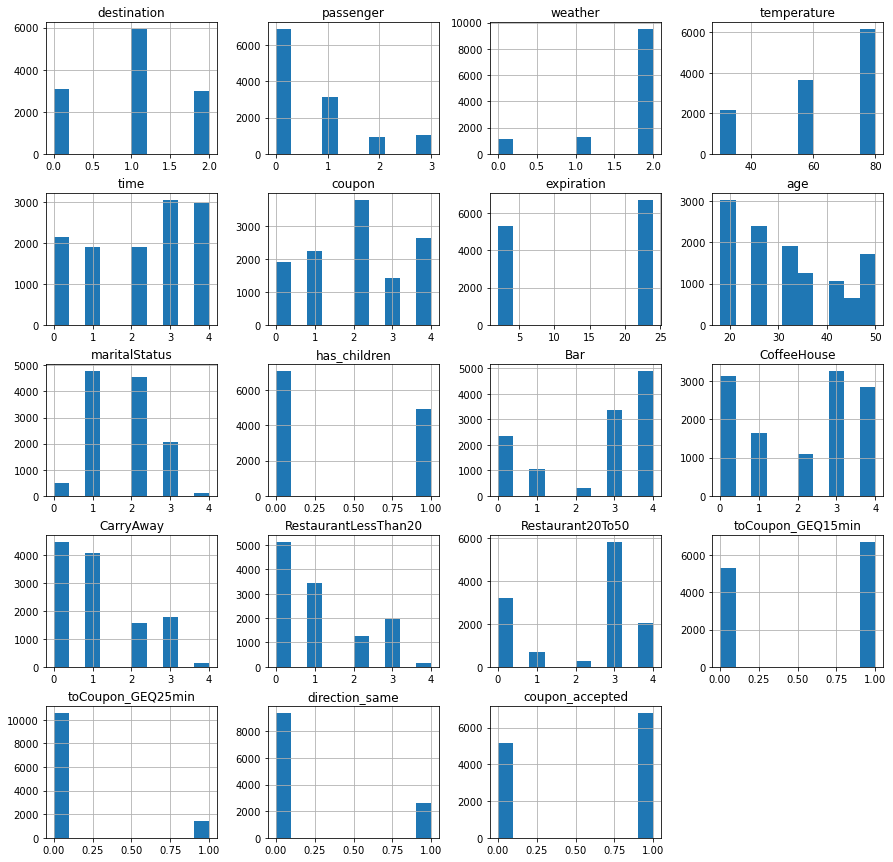

In [31]:
# for better visualization of outlier we also observe the histogram of the columns
df.hist(figsize=(15,15))

<AxesSubplot:>

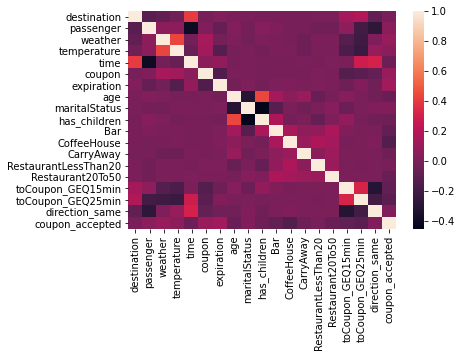

In [32]:
# to recheck if any correlation still exist
fig, ax = plt.subplots()
sns.heatmap(df.corr())

In [33]:
# At last we check if all the columns type are correct before applying ml algorithms
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12007 entries, 22 to 12683
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   destination           12007 non-null  int32
 1   passenger             12007 non-null  int32
 2   weather               12007 non-null  int32
 3   temperature           12007 non-null  int64
 4   time                  12007 non-null  int32
 5   coupon                12007 non-null  int32
 6   expiration            12007 non-null  int32
 7   age                   12007 non-null  int32
 8   maritalStatus         12007 non-null  int32
 9   has_children          12007 non-null  int64
 10  Bar                   12007 non-null  int32
 11  CoffeeHouse           12007 non-null  int32
 12  CarryAway             12007 non-null  int32
 13  RestaurantLessThan20  12007 non-null  int32
 14  Restaurant20To50      12007 non-null  int32
 15  toCoupon_GEQ15min     12007 non-null  int64
 16  toC

### Separating data into test-train split and normalizing the data

In [69]:
# we separate the input and target variables
x = df.drop('coupon_accepted', axis = 1)
y = df.coupon_accepted

#Now, we use standard scaler from sklearn to normalize our data
scale = StandardScaler()
x = scale.fit_transform(x)

#Now, we divide our dataset into traning and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

#the size of traning and testing data
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (9605, 18) (9605,)
Test set: (2402, 18) (2402,)


## Algorithms taught in class


### Logistic regression

In [35]:
#we used sklearn to use logistic regression model to train our data and test it
#we train the logistic regression model using traning data
model = LogisticRegression().fit(x_train, y_train)
model

LogisticRegression()

[[ 431  347]
 [ 573 1051]]
Train set Accuracy:  0.6317542946382093
Test set Accuracy:  0.6169858451290591


Text(0.5, 257.44, 'Predicted coupon acceptance')

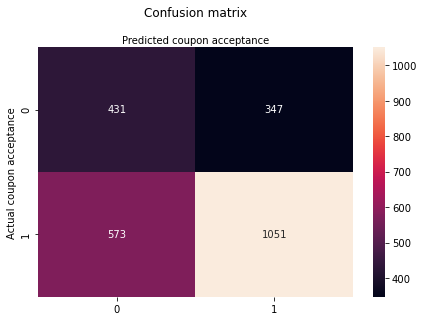

In [36]:
#we printed the confusion matrix with testing data 
print(confusion_matrix(model.predict(x_test), y_test))

#printed the traning and testing set accuracy to check for over and under-fitting of data
print("Train set Accuracy: ", accuracy_score(y_train, model.predict(x_train)))
print("Test set Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

#heat map with confusion matrix
fig, ax = plt.subplots()

class_names = [0,1]
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(model.predict(x_test), y_test)), annot = True, fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual coupon acceptance')
plt.xlabel('Predicted coupon acceptance')

In [37]:
#we train the logistic regression using polynomial feature to test for better performance
#we printed traning and testing accuracy for each polynomial degree and compared them
model_train_accuracy_per_degree = []
model_test_accuracy_per_degree = []
for deg in range(1,6):
    poly = PolynomialFeatures(degree = deg)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.fit_transform(x_test)
    model = LogisticRegression(max_iter = 100).fit(x_train_poly, y_train)
    print('degree =', deg,sep = '')
    print(confusion_matrix(model.predict(x_test_poly), y_test))
    
    model_train_accuracy_per_degree.append(accuracy_score(y_train, model.predict(x_train_poly)))
    model_test_accuracy_per_degree.append(accuracy_score(y_test, model.predict(x_test_poly)))
    
    print("Train set Accuracy: ", model_train_accuracy_per_degree[deg-1])
    print("Test set Accuracy: ", model_test_accuracy_per_degree[deg-1])
    print()

degree =1
[[ 431  347]
 [ 573 1051]]
Train set Accuracy:  0.6317542946382093
Test set Accuracy:  0.6169858451290591



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree =2
[[ 536  342]
 [ 468 1056]]
Train set Accuracy:  0.6773555439875065
Test set Accuracy:  0.6627810158201499



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree =3
[[ 636  371]
 [ 368 1027]]
Train set Accuracy:  0.7769911504424779
Test set Accuracy:  0.6923397169025812



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree =4
[[632 425]
 [372 973]]
Train set Accuracy:  0.9351379489849037
Test set Accuracy:  0.6681931723563697



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree =5
[[ 608  397]
 [ 396 1001]]
Train set Accuracy:  0.983237896928683
Test set Accuracy:  0.6698584512905912



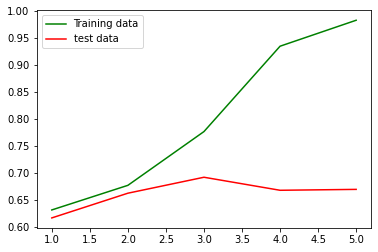

In [38]:
#this plot show the traning and testing accuracy vs polynomail degree used in logistic regression
#we can observe that as the degree of polynomial is increasing the traning accuracy is increasing but
#testing accuracy is remaining the same, this tells us that the model is overfitting.
#hence, we are using a logictic regression with atmost degree 2 and compare it with other models.
row = [1, 2, 3, 4, 5]
plt.figure()
plt.plot(row, model_train_accuracy_per_degree, 'g-', label = 'Training data')
plt.plot(row, model_test_accuracy_per_degree, 'r-', label = 'test data')
plt.legend()

In [43]:
poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)
model = LogisticRegression(max_iter = 100).fit(x_train_poly, y_train)
print('degree =', 2,sep = '')
print(classification_report(model.predict(x_test_poly), y_test))    
   
print("Train set Accuracy: ", accuracy_score(y_train, model.predict(x_train_poly)))
print("Test set Accuracy: ", accuracy_score(y_test, model.predict(x_test_poly)))


degree =2
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       878
           1       0.76      0.69      0.72      1524

    accuracy                           0.66      2402
   macro avg       0.64      0.65      0.65      2402
weighted avg       0.67      0.66      0.67      2402

Train set Accuracy:  0.6773555439875065
Test set Accuracy:  0.6627810158201499


C:\Users\suraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### K-NN 

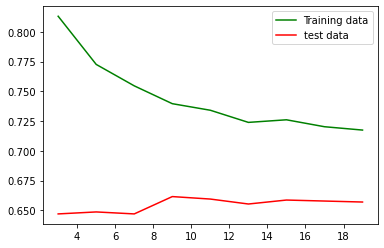

In [53]:
#now, we use a knn model to train our data
#we are using a range from 3-21 for out knn model to find optimum value of k
accuracy = []
t_accu = []
for k in range(3,21,2):
    model = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)    
    accuracy.append(accuracy_score(y_test, model.predict(x_test)))
    t_accu.append(accuracy_score(y_train, model.predict(x_train)))
row = np.arange(3,21,2)
plt.figure()
plt.plot(row, t_accu, 'g-', label = 'Training data')
plt.plot(row, accuracy, 'r-', label = 'test data')
plt.legend()
#we can observe that as the value of k is increasing the model is performing better and not overfitting the traning data

In [45]:
#Now we used grid serach for finding the optimal value of k as well as how to calculate the weights of the model
model = KNeighborsClassifier()

param_grid = {'weights': ['uniform', 'distance'],
 'n_neighbors': [1,3,5,7,9,11]}

#we fit the model in each combination of parameter specified above and train the model and get the accuracy score of each model
model_test = GridSearchCV(model, param_grid = param_grid, n_jobs = -1, verbose = True, cv = 3)
model_test.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    7.3s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [46]:
#printing the beast score along with the best estimator that got us the result
print(model_test.best_score_)
print(model_test.best_estimator_)
print(model_test.best_params_)

0.6584072240073322
KNeighborsClassifier(n_neighbors=11, weights='distance')
{'n_neighbors': 11, 'weights': 'distance'}


In [47]:
#now we train the model with above estimators and save the result for future reference
model = KNeighborsClassifier(n_neighbors = 11, weights = 'distance').fit(x_train, y_train)
model

KNeighborsClassifier(n_neighbors=11, weights='distance')

              precision    recall  f1-score   support

           0       0.53      0.61      0.57       880
           1       0.75      0.69      0.72      1522

    accuracy                           0.66      2402
   macro avg       0.64      0.65      0.64      2402
weighted avg       0.67      0.66      0.66      2402

Train set Accuracy:  0.9968766267568975
Test set Accuracy:  0.6594504579517069


Text(0.5, 257.44, 'Predicted coupon acceptance')

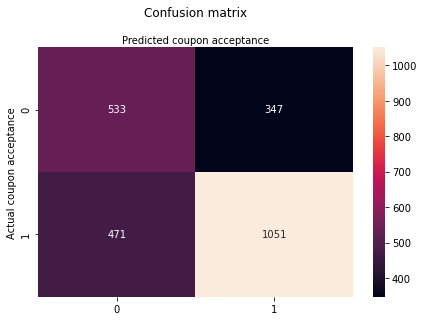

In [48]:
print(classification_report(model.predict(x_test), y_test))

print("Train set Accuracy: ", accuracy_score(y_train, model.predict(x_train)))
print("Test set Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

fig, ax = plt.subplots()

class_names = [0,1]
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(model.predict(x_test), y_test)), annot = True, fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual coupon acceptance')
plt.xlabel('Predicted coupon acceptance')

## Algorithms not taught in class

### SVM (support vector machine)

In [54]:
#now, we train a svm model with grid search to tune the hyper parameters
model = SVC()

param_grid = {'kernel': ['linear', 'rbf', 'poly'],
 'C': [1, 10, 100, 1000],
 'gamma': [0.01, 0.001, 0.0001]}

model_test = GridSearchCV(model, param_grid = param_grid, n_jobs = -1, verbose = True, cv = 3)
model_test.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.3min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=True)

In [55]:
#print the best score of model and its estimators
print(model_test.best_score_)
print(model_test.best_estimator_)
print(model_test.best_params_)

0.6877670306938097
SVC(C=1000, gamma=0.01)
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [56]:
#used the above estimators to train the model and print the accuracy and the heatmap of confusion matrix
model = SVC(kernel = 'rbf', C = 1000, gamma = 0.01).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       887
           1       0.78      0.72      0.75      1515

    accuracy                           0.69      2402
   macro avg       0.68      0.69      0.68      2402
weighted avg       0.70      0.69      0.70      2402

Train set Accuracy:  0.7495054659031755
Test set Accuracy:  0.6948376353039134


Text(0.5, 257.44, 'Predicted coupon acceptance')

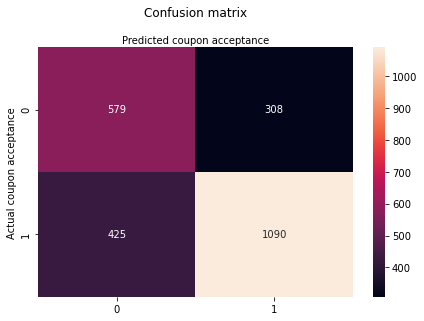

In [57]:
print(classification_report(model.predict(x_test), y_test))

print("Train set Accuracy: ", accuracy_score(y_train, model.predict(x_train)))
print("Test set Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

fig, ax = plt.subplots()

class_names = [0,1]
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(model.predict(x_test), y_test)), annot = True, fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual coupon acceptance')
plt.xlabel('Predicted coupon acceptance')

### Random Forest

In [58]:
#we used a randomforest model and used grid search for hyperparameter tuning
model = RandomForestClassifier()

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 12, 14, 16, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 800]}

model_test = GridSearchCV(model, param_grid = param_grid, n_jobs = -1, verbose = True, cv = 3)
model_test.fit(x_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  7.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 12, 14, 16, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 800]},
             verbose=True)

In [59]:
#print the best score of model and its estimators
print(model_test.best_score_)
print(model_test.best_estimator_)
print(model_test.best_params_)

0.7243092300884788
RandomForestClassifier(max_depth=14, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=400)
{'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}


              precision    recall  f1-score   support

           0       0.63      0.70      0.66       898
           1       0.81      0.75      0.78      1504

    accuracy                           0.73      2402
   macro avg       0.72      0.73      0.72      2402
weighted avg       0.74      0.73      0.74      2402

Train set Accuracy:  0.8754815200416449
Test set Accuracy:  0.7343880099916736


Text(0.5, 257.44, 'Predicted coupon acceptance')

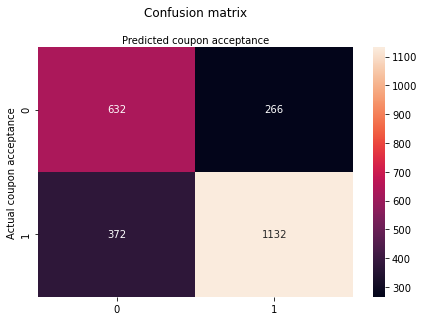

In [70]:
#used the above estimators to train the model and print the accuracy and the heatmap of confusion matrix
model = RandomForestClassifier(bootstrap = True,
                               max_features = 'sqrt',
                               min_samples_leaf = 2,
                               min_samples_split = 10,
                               n_estimators = 400, 
                               max_depth = None).fit(x_train, y_train)

print(classification_report(model.predict(x_test), y_test))

print("Train set Accuracy: ", accuracy_score(y_train, model.predict(x_train)))
print("Test set Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

fig, ax = plt.subplots()

class_names = [0,1]
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(model.predict(x_test), y_test)), annot = True, fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual coupon acceptance')
plt.xlabel('Predicted coupon acceptance')

### Neural Network

In [61]:
#next we made a neural network model to train our data
labels = pd.get_dummies(df.coupon_accepted, prefix='condition')
y=labels.values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print('training data shape={}'.format(X_train.shape))
print('testing data shape={}'.format(X_test.shape))
print('traning target shape={}'.format(y_train.shape))
print('testing target shape={}'.format(y_test.shape))

training data shape=(9605, 18)
testing data shape=(2402, 18)
traning target shape=(9605, 2)
testing target shape=(2402, 2)


In [62]:
#create a neural network using tensorflow
input_layer = Input(shape=(X_train.shape[1],))
dense_layer_1 = Dense(32,activation='relu')(input_layer)
dense_layer_2 = Dense(32,activation='relu')(dense_layer_1)
dense_layer_3 = Dense(8,activation='relu')(dense_layer_2)
dense_layer_4 = Dense(8, activation = 'relu')(dense_layer_3)
output = Dense(y_train.shape[1],activation='softmax')(dense_layer_4)

model = tf.keras.models.Model(inputs = input_layer, outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [63]:
#summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                608       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 2,018
Trainable params: 2,018
Non-trainable params: 0
___________________________________________________________

In [64]:
#train the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/100
301/301 [==============================] - 3s 4ms/step - loss: 0.6720 - acc: 0.5632 - val_loss: 0.6459 - val_acc: 0.6141
Epoch 2/100
301/301 [==============================] - 1s 3ms/step - loss: 0.6296 - acc: 0.6478 - val_loss: 0.6398 - val_acc: 0.6274
Epoch 3/100
301/301 [==============================] - 1s 3ms/step - loss: 0.6172 - acc: 0.6500 - val_loss: 0.6383 - val_acc: 0.6316
Epoch 4/100
301/301 [==============================] - 1s 3ms/step - loss: 0.6074 - acc: 0.6689 - val_loss: 0.6356 - val_acc: 0.6324
Epoch 5/100
301/301 [==============================] - 1s 3ms/step - loss: 0.6047 - acc: 0.6632 - val_loss: 0.6373 - val_acc: 0.6378
Epoch 6/100
301/301 [==============================] - 1s 3ms/step - loss: 0.5931 - acc: 0.6812 - val_loss: 0.6349 - val_acc: 0.6449
Epoch 7/100
301/301 [==============================] - 1s 3ms/step - loss: 0.5800 - acc: 0.6927 - val_loss: 0.6251 - val_acc: 0.6536
Epoch 8/100
301/301 [==============================] - 1s 3ms/step - 

301/301 [==============================] - 1s 3ms/step - loss: 0.4590 - acc: 0.7864 - val_loss: 0.6971 - val_acc: 0.6653
Epoch 63/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4403 - acc: 0.7976 - val_loss: 0.7065 - val_acc: 0.6520
Epoch 64/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4437 - acc: 0.7960 - val_loss: 0.7070 - val_acc: 0.6590
Epoch 65/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4461 - acc: 0.7880 - val_loss: 0.7188 - val_acc: 0.6549
Epoch 66/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4443 - acc: 0.7850 - val_loss: 0.7143 - val_acc: 0.6599
Epoch 67/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4485 - acc: 0.7858 - val_loss: 0.7243 - val_acc: 0.6490
Epoch 68/100
301/301 [==============================] - 1s 3ms/step - loss: 0.4517 - acc: 0.7915 - val_loss: 0.7102 - val_acc: 0.6557
Epoch 69/100
301/301 [==============================] - 1s 3ms/step - loss:

In [65]:
#evaluation of the model
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

76/76 [==============================] - 0s 2ms/step - loss: 0.7602 - acc: 0.6536
Test Score: 0.7601813077926636
Test Accuracy: 0.6536219716072083


In [66]:
#converstion of training and testing data to create confusion matrix and get the accuracy score
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

y_pred = y_pred.argmax(axis = 1)
y_test = y_test.argmax(axis = 1)
y_pred_train = y_pred_train.argmax(axis = 1)
y_train = y_train.argmax(axis = 1)

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       931
           1       0.73      0.68      0.71      1471

    accuracy                           0.65      2402
   macro avg       0.64      0.65      0.64      2402
weighted avg       0.66      0.65      0.66      2402

Train set Accuracy:  0.813430504945341
Test set Accuracy:  0.6536219816819318


Text(0.5, 257.44, 'Predicted coupon acceptance')

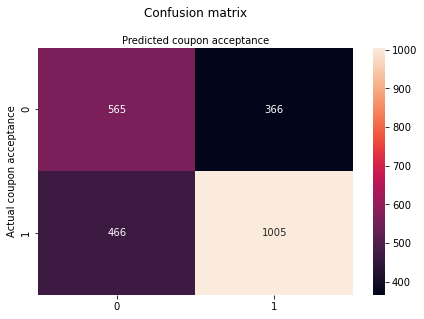

In [67]:
print(classification_report(y_pred, y_test))

print("Train set Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test set Accuracy: ", accuracy_score(y_test, y_pred))

fig, ax = plt.subplots()

class_names = [0,1]
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred, y_test)), annot = True, fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual coupon acceptance')
plt.xlabel('Predicted coupon acceptance')

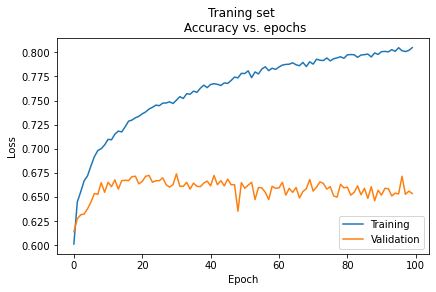

In [68]:
fig,ax=plt.subplots()
 
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])

ax.set_title('Traning set \n Accuracy vs. epochs')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Training', 'Validation'], loc='lower right')
plt.tight_layout(pad=0.5,w_pad=2)